# Twitter Cluster
In this notebook file we had implemented a clusters analysis on a Twitter's profiles related of the file S21.tsv.
After a careful evaluation of the various library that Python offers for our scope, we had choice the official API of Twitter in order to get the various information on twitter profiles.

In [1]:
import twitter
import pandas as pd
import json
import datetime
import csv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

api = twitter.Api(consumer_key='2Nn22OkPPZaBoarCjxcP7Tr70',
                  consumer_secret='9VdkWxOFvmrnjEzbG3SoMkh9kPKB5ToHb6RKnwGyso8XrAlPk2',
                  access_token_key='204761432-jUj8moOZ6ccKo7s48ufl8mpPB3amryzzvidYIhDA',
                  access_token_secret='2XVFSENxf7RNqwysvHYsSh1j5itKpdItJtA6khjxd7Dxp',
                  sleep_on_rate_limit = True )

api.VerifyCredentials()


User(ID=204761432, ScreenName=Ivan_FCT)

## Crawling Twitter Friendship Data
We started with an analysis based on friendship information. For each twitter's profile we get, throught the functions provided to Twitter API (getFriendsID(...) and getFollowersID(...)), we retrive the list of IDs that all our users follow and the list of IDs that follow our users. <br>
This computation is very slow because Twitter API allow to retrive this information for 15 user every 15 minutes. So for each iteration we print summary information of the data obtained in order to try to understand at what point is the execution of the process.

In [ ]:

with open("S21.tsv") as f:
    reader = csv.reader(f)
    s21 = []
    for row in reader:
        s21.append(int(row[0]))

count = 0
data = {}
 

for id_user in s21:
    if id_user in data.keys():
        continue
    else:
        try:
            data[id_user] = api.GetFriendIDs(user_id=id_user)
            tot = len(data[id_user])
            count += 1
            with open("friends_id.json", "w") as write_file:
                json.dump(data, write_file)
            print(id_user , ' ----> DONE! N°:', count, '- TOT_FRIENDS:', tot, '- WHEN: ', datetime.datetime.now().time())
            write_file.close()
        
        except Exception as err:
            print(err)
            
for id_user in s21:
    if id_user in data.keys():
        continue
    else:
        try:
            data[id_user] = api.GetFollowerIDs(user_id=id_user)
            tot = len(data[id_user])
            count += 1
            with open("followers_id.json", "w") as write_file:
                json.dump(data, write_file)
            print(id_user , ' ----> DONE! N°:', count, '- TOT_FOLLOWERS:', tot, '- WHEN: ', datetime.datetime.now().time())
            write_file.close()
        
        except Exception as err:
            print(err)
            

        
        

After 30 hours of execution we have our list of friends and followers that we have stored in JSON file. <br>
At this point we create the intersection of this two sets, in order to obtain only the IDs that follow our users and that our users following too.

In [14]:
with open("friends_id.json", "r") as read_file:
    friends = json.load(read_file)

print('Tot friend_id keys:',len(friends.keys()))

with open("followers_id.json", "r") as read_file:
    follows = json.load(read_file)
    
print('Tot followers_id keys:',len(follows.keys()))

keys_a = set(friends.keys())
keys_b = set(follows.keys())
intersection = keys_a & keys_b

print('Tot keys in comune trovate:',len(intersection))

result = {}
tot_follow = []
for _id in intersection:
    result[_id] = set(friends[_id]) & set(follows[_id])
    
for lista in result.values():
    for v in lista:
        tot_follow.append(v)
    
print('Totale user trovati:', len(set(tot_follow)))



Tot friend_id keys: 1420
Tot followers_id keys: 1433
Tot keys in comune trovate: 1411
Totale user trovati: 760810


Now, at each ID of our intersection set we associate a number that we will use in the one hot encoding function below. <br>
So user mapper's length is the same length of our intersection sets.

In [3]:

user_mapper = {}
c = 0

for user in result:
    for follower in result[user]:
        if follower not in user_mapper:
            user_mapper[str(follower)] = c
            c += 1


In [4]:
len(user_mapper)

760810

The function one_hot_encoding take as parameter the list of intersection between followers/friends and the user mapper and create one hot vector for each user in S21 file, that is a vector with length of 760810 that have only zeros or 1.

In [2]:
def one_hot_encoding(follower_list, mapper):
    v = np.zeros(len(mapper))
    for follower in follower_list:
        try:
            position = mapper[str(follower)]
            v[position] = 1
        except:
            pass
    return v

dataset = [one_hot_encoding(result[user], user_mapper) for user in result]
len(dataset[1])

In order to make our results viewable through plot we use PCA to obrain for each vector a couple of number.

In [15]:
del result
pca = PCA(n_components=2).fit(dataset)
pca_2d = pca.transform(dataset)

In [18]:
pca_2d

Our friendship information are not informative enough, this may be due to the few friendships our users have in common, in fact we can see how all the users, represented by points in the plot below, are concentrated in the same area. <br>
So we can change our strategy!

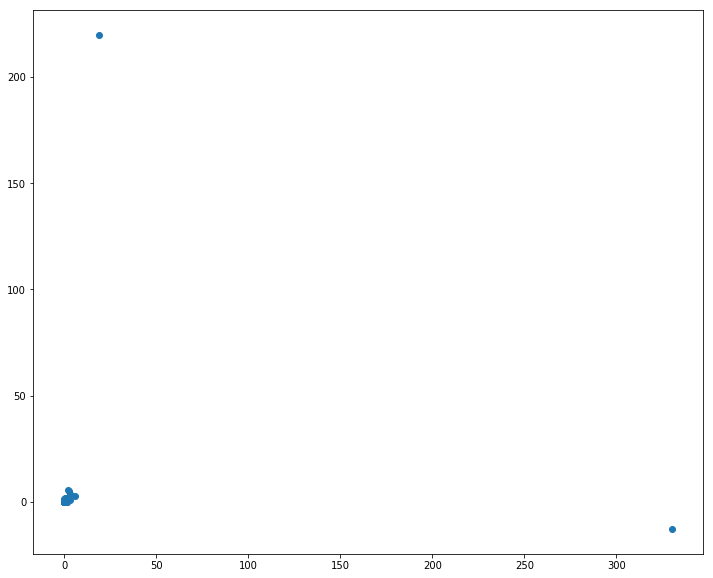

In [23]:
plt.figure(figsize=(12,10))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])
plt.show()

In [21]:
kmeans = KMeans(n_clusters=2).fit(pca_2d)
y_kmeans = kmeans.predict(pca_2d)

## Crawling Twitter Hashtag Data
We change our strategy: now we want explore the last hashtag used by our users given by the S21.tsv file! <br>
This time we will use the function named GetUserTimeline(...) with parameter count=100, that give us the list of last 100 tweet for each user. Starting from this tweets we can retrieve the hashtag that each user have used.

In [ ]:
with open("S21.tsv") as f:
    reader = csv.reader(f)
    s21 = []
    for row in reader:
        s21.append(int(row[0]))

count = 0
data = {}
 

for id_user in s21:
    if id_user in data.keys():
        continue
    else:
        try:
            t = api.GetUserTimeline(user_id=id_user, count=100)
            tweets = [i.AsDict() for i in t]
            data[id_user] = [tweet['hashtags'][0]['text'] for tweet in tweets if tweet['hashtags']]
            tot = len(data[id_user])
            count += 1
            with open("hashtags.json", "w") as write_file:
                json.dump(data, write_file)
            print(id_user , ' ----> DONE! N°:', count, '- TOT_HASHTAG:', tot, '- WHEN: ', datetime.datetime.now().time())
            write_file.close()
        
        except Exception as err:
            print(err)
            

        

As before, we stored all the hashtag retrieved in a JSON file, then we map again all the hashtags and finally we create our second dataset with one hot vector for each user mapped on his hashtags. 

In [4]:
with open("hashtags.json", "r") as read_file:
    hashtags = json.load(read_file)

tot_hash = []
for lista in hashtags.values():
    for v in lista:
        tot_hash.append(v)
    
print('Totale hashtag trovati:', len(set(tot_hash)))

h = 0
hash_mapper = {}
for hashtg in tot_hash:
    if hashtg not in hash_mapper:
        hash_mapper[str(hashtg)] = h
        h += 1

print('Numero chiavi hash_mapper:', len(hash_mapper.keys()))

dataset_hash = [one_hot_encoding(hashtags[hashtg], hash_mapper) for hashtg in hashtags]
print('---> dataset_hash sarà una matrice', len(dataset_hash), 'x', len(dataset_hash[0]))

Totale hashtag trovati: 11419
Numero chiavi hash_mapper: 11419
---> dataset_hash sarà una matrice 1422 x 11419


Again we compute PCA analysis in order to obtain results that we can plot

In [5]:
pca = PCA(n_components=2).fit(dataset_hash)
pca_2d = pca.transform(dataset_hash)

In [6]:
pca_2d.shape

(1422, 2)

In [7]:
pca_2d

array([[ 0.88422247, -0.00285513],
       [-0.14671981, -0.00672723],
       [-0.15131576, -0.00716176],
       ...,
       [-0.15712744, -0.00809285],
       [-0.14671981, -0.00672723],
       [-0.11236289, -0.01152587]])

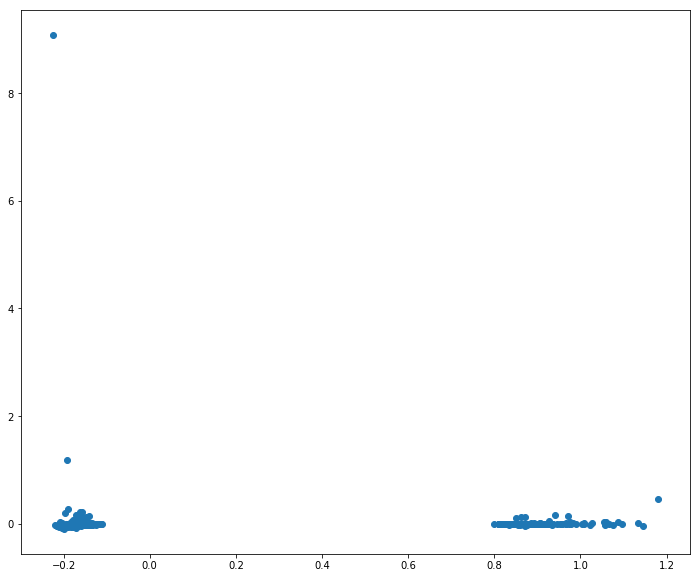

In [8]:
plt.figure(figsize=(12,10))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])
plt.show()

Using hashtags as a comparison item between users we obtain a good result. All the users are clustered in 2 macro area where the red X are the centroids of the cluster and only few users are clustered in another point (this may refers to users with only 1 hashtag found).

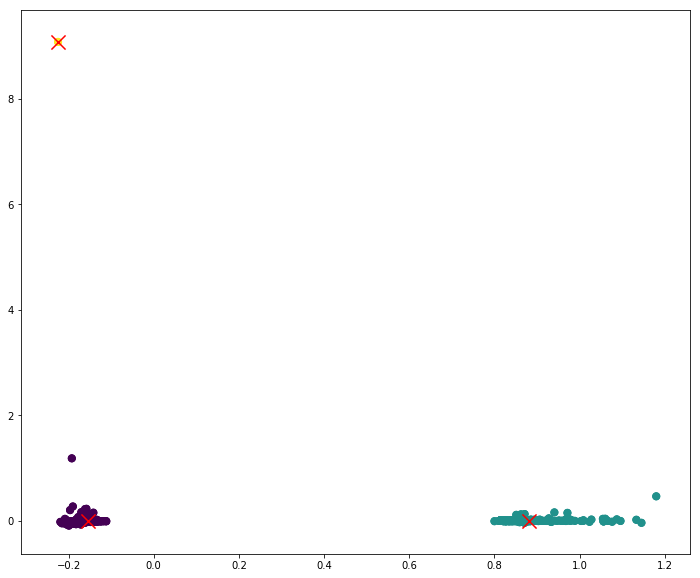

In [9]:
kmeans = KMeans(n_clusters=3).fit(pca_2d)
y_kmeans = kmeans.predict(pca_2d)
plt.figure(figsize=(12, 10))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_kmeans, s=50)
centroids = kmeans.cluster_centers_
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_kmeans, s=50);
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='x', c='red')
plt.show()